In [1]:
import numpy as np
import pylab as plt
from glob import glob
import os
from fnmatch import filter
from scipy.stats import zscore
import pymc3 as pm
from theano import tensor as tt
from sklearn.impute import SimpleImputer

In [2]:
data_dir = '/media/fastdata/brad_changepoint/raw_data/'

In [3]:
file_list = glob(os.path.join(data_dir,"*.npy"))
lfp_files = [x for x in file_list if 'rear' not in x]
rear_files = [x for x in file_list if 'rear' in x]

In [4]:
load_groups = [['cons1','cons2'],['exps1','expl1']]
lfp_groups = [[[x for x in lfp_files if name in x] for name in group] for group in load_groups]
rear_groups = [[[x for x in rear_files if name in x] for name in group] for group in load_groups]
lfp_groups = np.squeeze(np.array(lfp_groups))
rear_groups = np.squeeze(np.array(rear_groups))

In [5]:
lfp_groups

array([['/media/fastdata/brad_changepoint/raw_data/cons1.npy',
        '/media/fastdata/brad_changepoint/raw_data/cons2.npy'],
       ['/media/fastdata/brad_changepoint/raw_data/exps1.npy',
        '/media/fastdata/brad_changepoint/raw_data/expl1.npy']],
      dtype='<U51')

In [6]:
rear_groups

array([['/media/fastdata/brad_changepoint/raw_data/rear_cons1.npy',
        '/media/fastdata/brad_changepoint/raw_data/rear_cons2.npy'],
       ['/media/fastdata/brad_changepoint/raw_data/rear_exps1.npy',
        '/media/fastdata/brad_changepoint/raw_data/rear_expl1.npy']],
      dtype='<U56')

# ==== LFP ====

In [7]:
lfp_dat = np.array([[np.load(x,'r')[:] for x in group] for group in lfp_groups])
zscore_lfp_dat = np.array([[zscore(np.load(x,'r')[:],axis=-1) for x in group] for group in lfp_groups])

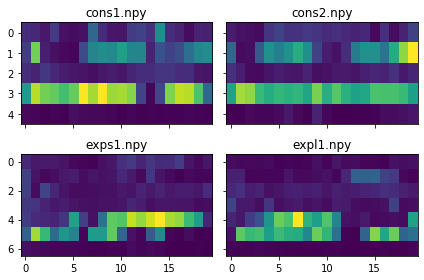

In [8]:
inds = list(np.ndindex(lfp_dat.shape))
fig,ax = plt.subplots(2,2,sharex=True, sharey = 'row')
for this_ind in inds:
    ax[this_ind].imshow(lfp_dat[this_ind],aspect='auto')
    ax[this_ind].set_title(os.path.basename(lfp_groups[this_ind]))
plt.tight_layout()

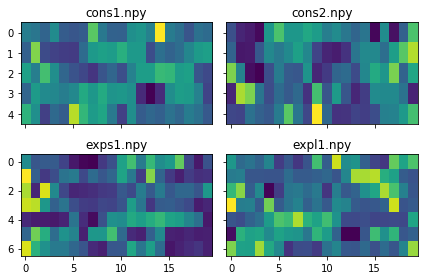

In [9]:
inds = list(np.ndindex(lfp_dat.shape))
fig,ax = plt.subplots(2,2,sharex=True, sharey = 'row')
for this_ind in inds:
    ax[this_ind].imshow(zscore_lfp_dat[this_ind],aspect='auto')
    ax[this_ind].set_title(os.path.basename(lfp_groups[this_ind]))
plt.tight_layout()

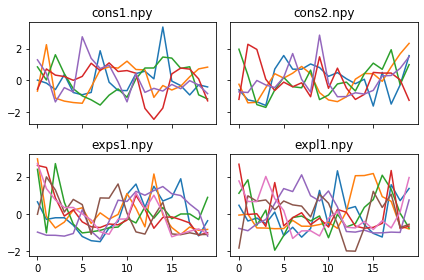

In [10]:
inds = list(np.ndindex(lfp_dat.shape))
fig,ax = plt.subplots(2,2,sharex=True, sharey = 'row')
for this_ind in inds:
    ax[this_ind].plot(zscore_lfp_dat[this_ind].T)
    ax[this_ind].set_title(os.path.basename(lfp_groups[this_ind]))
plt.tight_layout()

In [11]:
lfp_groups.flatten()

array(['/media/fastdata/brad_changepoint/raw_data/cons1.npy',
       '/media/fastdata/brad_changepoint/raw_data/cons2.npy',
       '/media/fastdata/brad_changepoint/raw_data/exps1.npy',
       '/media/fastdata/brad_changepoint/raw_data/expl1.npy'],
      dtype='<U51')

### Con Model

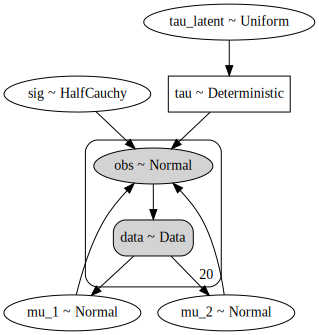

In [12]:
with pm.Model() as mean_model:
    
    # Define shared "Data" holder to fit same model to different datasets 
    data = pm.Data("data", zscore_lfp_dat[0,0][0])
    # Defining variables with priors
    alpha = data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)
    sigma = pm.HalfCauchy('sig', 1)

    idx = np.arange(np.array(mean_model["data"].get_value()).shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    mu_ = (1 - weight) * mu_1 + weight * mu_2

    observation = pm.Normal("obs", mu=mu_, sigma = sigma, observed=data)

pm.model_to_graphviz(mean_model)

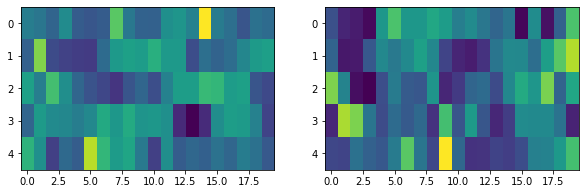

In [13]:
fig, ax = plt.subplots(1,2, figsize = (10,3))
for this_ax,dat in zip(ax,zscore_lfp_dat[0]):
    this_ax.imshow(dat,aspect='auto')

In [14]:
# Generate one trace for each dataset
con1_traces = []
for data_vals in zscore_lfp_dat[0,0]:
    with mean_model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        con1_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))
        
# Generate one trace for each dataset
con2_traces = []
for data_vals in zscore_lfp_dat[0,1]:
    with mean_model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        con2_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2079.32draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2027.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2133.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing

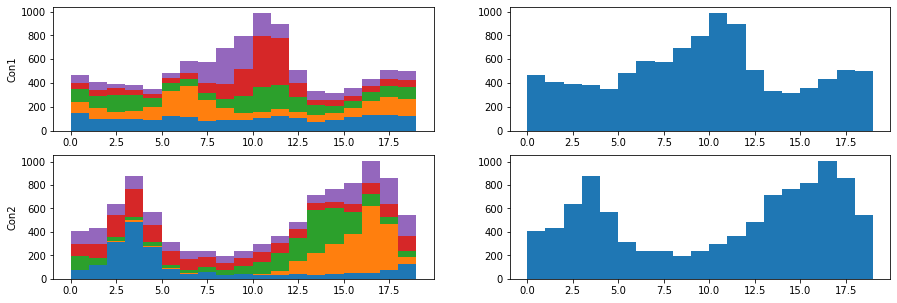

In [15]:
con1_tau_array = np.array([this_trace["tau"] for this_trace in con1_traces])
con2_tau_array = np.array([this_trace["tau"] for this_trace in con2_traces])

fig, ax = plt.subplots(2,2, figsize = (15,5))
ax[0,0].hist(con1_tau_array.T, np.arange(20), stacked = 'true');
ax[0,1].hist(con1_tau_array.flatten(), np.arange(20), stacked = 'true');
ax[1,0].hist(con2_tau_array.T, np.arange(20), stacked = 'true');
ax[1,1].hist(con2_tau_array.flatten(), np.arange(20), stacked = 'true');

ax[0,0].set_ylabel('Con1');
ax[1,0].set_ylabel('Con2');

In [16]:
con1_tau_hists = np.array([np.histogram(x, np.arange(20))[0] for x in con1_tau_array])
con2_tau_hists = np.array([np.histogram(x, np.arange(20))[0] for x in con2_tau_array])

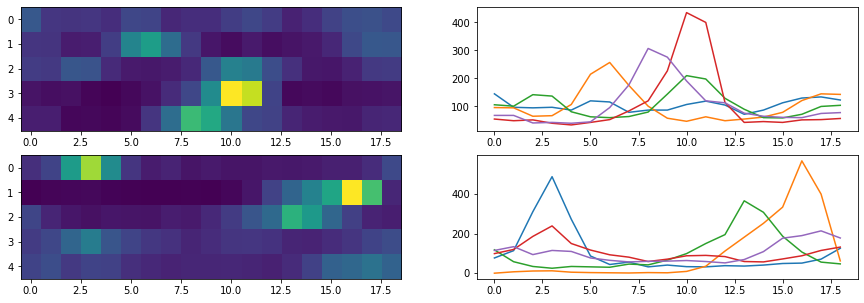

In [17]:
fig,ax = plt.subplots(2,2, figsize = (15,5))
ax[0,0].imshow(con1_tau_hists,aspect='auto');
ax[1,0].imshow(con2_tau_hists,aspect='auto');
ax[0,1].plot(con1_tau_hists.T);
ax[1,1].plot(con2_tau_hists.T);

### Exp Model

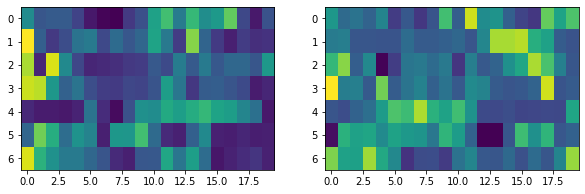

In [18]:
fig, ax = plt.subplots(1,2, figsize = (10,3))
for this_ax,dat in zip(ax,zscore_lfp_dat[1]):
    this_ax.imshow(dat,aspect='auto')

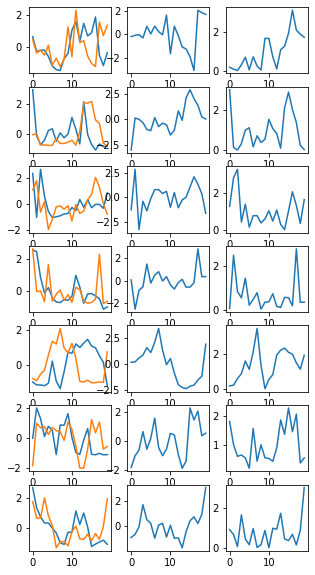

In [19]:
rows = zscore_lfp_dat[1,0].shape[0]
fig, ax = plt.subplots(rows, 3, figsize = (5,10))
for num in range(rows):
    ax[num,0].plot(zscore_lfp_dat[1,0][num])
    ax[num,0].plot(zscore_lfp_dat[1,1][num])
    ax[num,1].plot(zscore_lfp_dat[1,1][num] - zscore_lfp_dat[1,0][num])
    ax[num,2].plot(np.abs(zscore_lfp_dat[1,1][num] - zscore_lfp_dat[1,0][num]))

In [20]:
# Generate one trace for each dataset
exp1_traces = []
for data_vals in zscore_lfp_dat[1,0]:
    with mean_model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        exp1_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))
        
# Generate one trace for each dataset
exp2_traces = []
for data_vals in zscore_lfp_dat[1,1]:
    with mean_model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        exp2_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2008.06draws/s]
The acceptance probability does not match the target. It is 0.6344906543467312, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6556305095936011, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2001.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jit

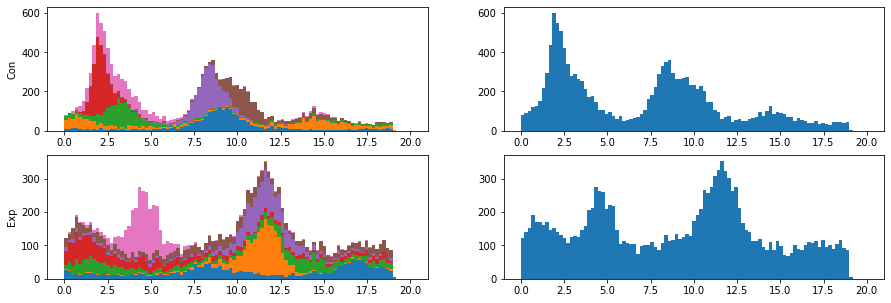

In [21]:
exp1_tau_array = np.array([this_trace["tau"] for this_trace in exp1_traces])
exp2_tau_array = np.array([this_trace["tau"] for this_trace in exp2_traces])

bins = np.linspace(0,20,100)
fig, ax = plt.subplots(2,2, figsize = (15,5))
ax[0,0].hist(exp1_tau_array.T, bins, stacked = 'true');
ax[0,1].hist(exp1_tau_array.flatten(), bins, stacked = 'true');
ax[1,0].hist(exp2_tau_array.T, bins, stacked = 'true');
ax[1,1].hist(exp2_tau_array.flatten(), bins, stacked = 'true');

ax[0,0].set_ylabel('Con');
ax[1,0].set_ylabel('Exp');

In [23]:
exp1_tau_hists = np.array([np.histogram(x, bins)[0] for x in exp1_tau_array])
exp2_tau_hists = np.array([np.histogram(x, bins)[0] for x in exp2_tau_array])

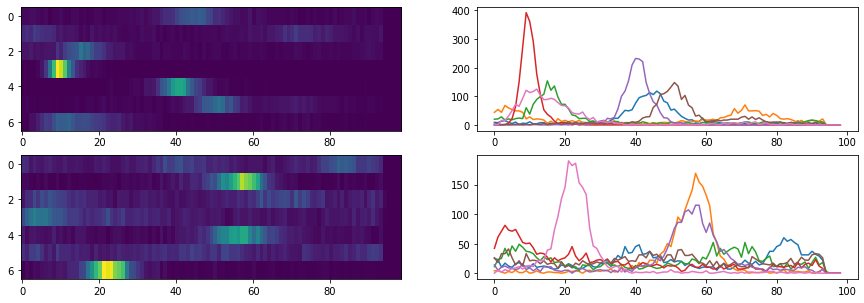

In [24]:
fig,ax = plt.subplots(2,2, figsize = (15,5))
ax[0,0].imshow(exp1_tau_hists,aspect='auto');
ax[1,0].imshow(exp2_tau_hists,aspect='auto');
ax[0,1].plot(exp1_tau_hists.T);
ax[1,1].plot(exp2_tau_hists.T);

### ==== Diff Changes ====

In [25]:
exp_diff_lfp = np.diff(zscore_lfp_dat[1], axis=0)[0]

In [26]:
# Generate one trace for each dataset
exp_diff_traces = []
for data_vals in exp_diff_lfp:
    with mean_model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        exp_diff_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2068.06draws/s]
The acceptance probability does not match the target. It is 0.720347289555964, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2486.23draws/s]
The acceptance probability does not match the target. It is 0.7191586358896956, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7044289044427342, but should be close to 0.8. Try to increase the numb

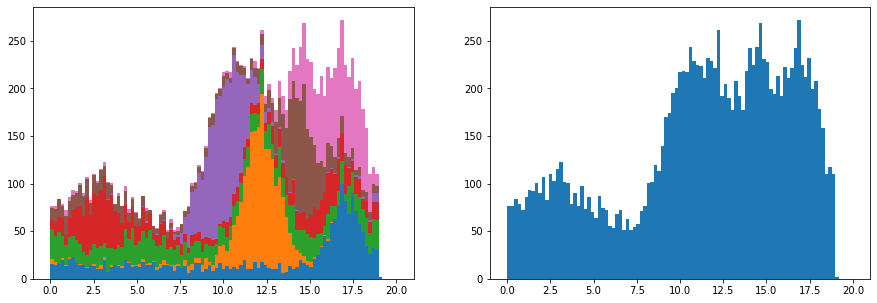

In [27]:
exp_diff_tau_array = np.array([this_trace["tau"] for this_trace in exp_diff_traces])

bins = np.linspace(0,20,100)
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].hist(exp_diff_tau_array.T, bins, stacked = 'true');
ax[1].hist(exp_diff_tau_array.flatten(), bins, stacked = 'true');

#ax[0,0].set_ylabel('Con');
#ax[1,0].set_ylabel('Exp');

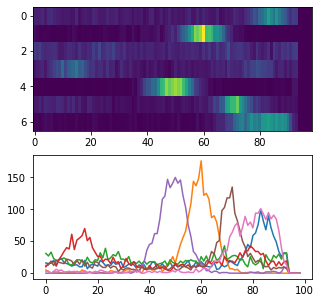

In [28]:
exp_diff_tau_hists = np.array([np.histogram(x, bins)[0] for x in exp_diff_tau_array])
fig,ax = plt.subplots(2,1, figsize = (5,5))
ax[0].imshow(exp_diff_tau_hists,aspect='auto');
ax[1].plot(exp_diff_tau_hists.T);

In [29]:
con_diff_lfp = np.diff(zscore_lfp_dat[0], axis=0)[0]

In [30]:
# Generate one trace for each dataset
con_diff_traces = []
for data_vals in con_diff_lfp:
    with mean_model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        con_diff_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2169.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1879.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2177.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing

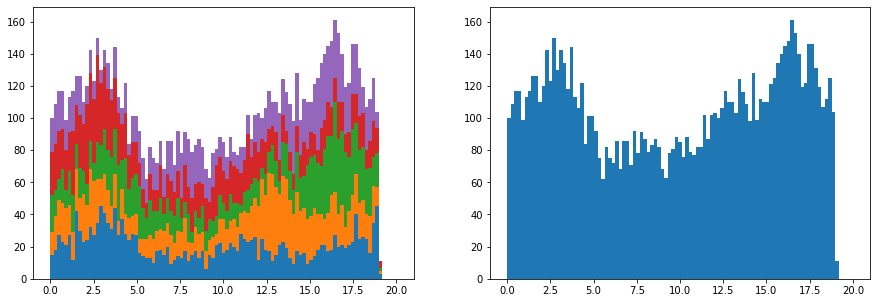

In [31]:
con_diff_tau_array = np.array([this_trace["tau"] for this_trace in con_diff_traces])

bins = np.linspace(0,20,100)
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].hist(con_diff_tau_array.T, bins, stacked = 'true');
ax[1].hist(con_diff_tau_array.flatten(), bins, stacked = 'true');

#ax[0,0].set_ylabel('Con');
#ax[1,0].set_ylabel('Exp');

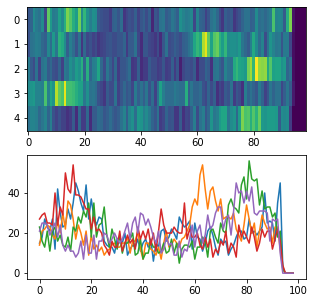

In [32]:
con_diff_tau_hists = np.array([np.histogram(x, bins)[0] for x in con_diff_tau_array])
fig,ax = plt.subplots(2,1, figsize = (5,5))
ax[0].imshow(con_diff_tau_hists,aspect='auto');
ax[1].plot(con_diff_tau_hists.T);

### ===== Comparison ===== 

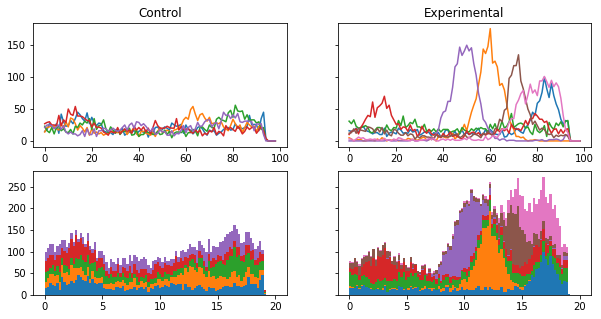

In [33]:
fig,ax = plt.subplots(2,2, figsize = (10,5), sharey = 'row')
ax[0,0].plot(con_diff_tau_hists.T);
ax[0,1].plot(exp_diff_tau_hists.T);
ax[1,0].hist(con_diff_tau_array.T, bins, stacked = 'true');
ax[1,1].hist(exp_diff_tau_array.T, bins, stacked = 'true');
ax[0,0].set_title('Control');
ax[0,1].set_title('Experimental');

# ==== Rearing ====

In [34]:
rear_dat = np.array([[np.load(x,'r')[:] for x in group] for group in rear_groups])
zscore_rear_dat = np.array([[zscore(np.load(x,'r')[:],axis=-1) for x in group] for group in rear_groups])
imputer = SimpleImputer(strategy = 'constant', fill_value = 0)
inds = np.ndindex(zscore_rear_dat.shape)
for this_ind in inds:
    zscore_rear_dat[this_ind] = imputer.fit_transform(zscore_rear_dat[this_ind])

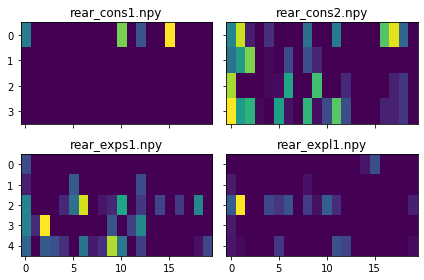

In [35]:
inds = list(np.ndindex(rear_dat.shape))
fig,ax = plt.subplots(2,2,sharex=True, sharey = 'row')
for this_ind in inds:
    ax[this_ind].imshow(rear_dat[this_ind],aspect='auto')
    ax[this_ind].set_title(os.path.basename(rear_groups[this_ind]))
plt.tight_layout()

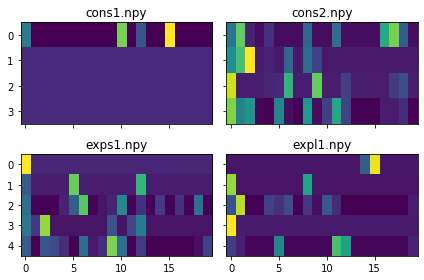

In [36]:
inds = list(np.ndindex(lfp_dat.shape))
fig,ax = plt.subplots(2,2,sharex=True, sharey = 'row')
for this_ind in inds:
    ax[this_ind].imshow(zscore_rear_dat[this_ind],aspect='auto')
    ax[this_ind].set_title(os.path.basename(lfp_groups[this_ind]))
plt.tight_layout()

## ==== Diff Changes MEAN MODEL ====

In [37]:
exp_diff_rear = np.diff(zscore_rear_dat[1], axis=0)[0]
con_diff_rear = np.diff(zscore_rear_dat[0], axis=0)[0]

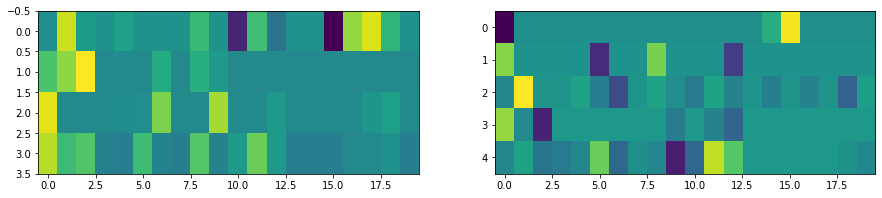

In [38]:
fig,ax = plt.subplots(1,2, figsize = (15,3))
ax[0].imshow(con_diff_rear,aspect='auto');
ax[1].imshow(exp_diff_rear,aspect='auto');

In [39]:
# Generate one trace for each dataset
exp_diff_traces = []
for data_vals in exp_diff_rear:
    with mean_model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        exp_diff_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))
        
# Generate one trace for each dataset
con_diff_traces = []
for data_vals in con_diff_rear:
    with mean_model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        con_diff_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2478.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2141.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2354.76draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 

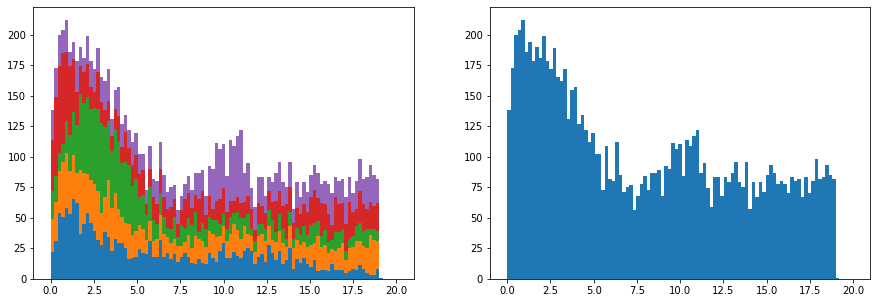

In [40]:
exp_diff_tau_array = np.array([this_trace["tau"] for this_trace in exp_diff_traces])

bins = np.linspace(0,20,100)
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].hist(exp_diff_tau_array.T, bins, stacked = 'true');
ax[1].hist(exp_diff_tau_array.flatten(), bins, stacked = 'true');

#ax[0,0].set_ylabel('Con');
#ax[1,0].set_ylabel('Exp');

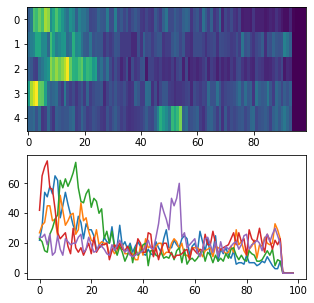

In [41]:
exp_diff_tau_hists = np.array([np.histogram(x, bins)[0] for x in exp_diff_tau_array])
fig,ax = plt.subplots(2,1, figsize = (5,5))
ax[0].imshow(exp_diff_tau_hists,aspect='auto');
ax[1].plot(exp_diff_tau_hists.T);

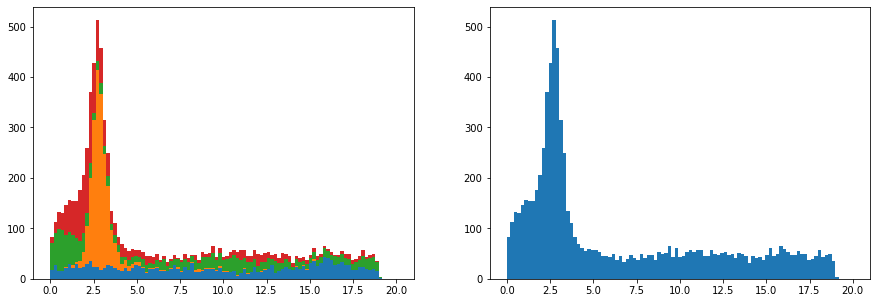

In [42]:
con_diff_tau_array = np.array([this_trace["tau"] for this_trace in con_diff_traces])

bins = np.linspace(0,20,100)
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].hist(con_diff_tau_array.T, bins, stacked = 'true');
ax[1].hist(con_diff_tau_array.flatten(), bins, stacked = 'true');

#ax[0,0].set_ylabel('Con');
#ax[1,0].set_ylabel('Exp');

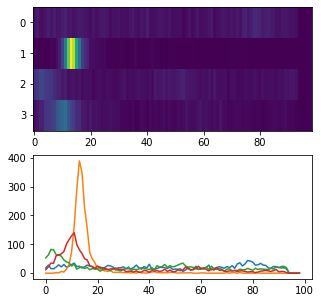

In [43]:
con_diff_tau_hists = np.array([np.histogram(x, bins)[0] for x in con_diff_tau_array])
fig,ax = plt.subplots(2,1, figsize = (5,5))
ax[0].imshow(con_diff_tau_hists,aspect='auto');
ax[1].plot(con_diff_tau_hists.T);

### ===== Comparison ===== 

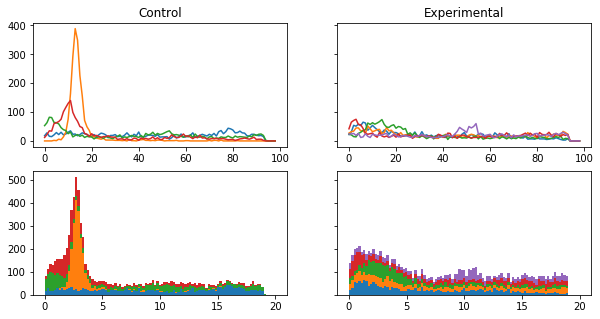

In [44]:
fig,ax = plt.subplots(2,2, figsize = (10,5), sharey = 'row')
ax[0,0].plot(con_diff_tau_hists.T);
ax[0,1].plot(exp_diff_tau_hists.T);
ax[1,0].hist(con_diff_tau_array.T, bins, stacked = 'true');
ax[1,1].hist(exp_diff_tau_array.T, bins, stacked = 'true');
ax[0,0].set_title('Control');
ax[0,1].set_title('Experimental');

## ==== Diff Changes 3 State MEAN MODEL ====

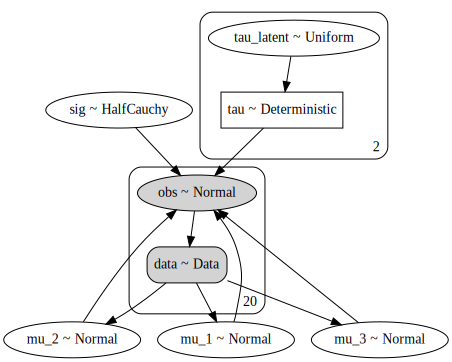

In [85]:
with pm.Model() as mean_model3:
    
    # Define shared "Data" holder to fit same model to different datasets 
    data = pm.Data("data", zscore_lfp_dat[0,0][0])
    # Defining variables with priors
    alpha = data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1, testval = 0)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1, testval = 10)
    mu_3 = pm.Normal("mu_3", mu=alpha, sigma = 1, testval = 0)
    sigma = pm.HalfCauchy('sig', 1)

    idx = np.arange(np.array(mean_model["data"].get_value()).shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1, shape = 2, testval = [0.3,0.6]).sort(axis=-1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight1 = tt.nnet.sigmoid(2 * (idx - tau[0]))
    weight2 = tt.nnet.sigmoid(2 * (idx - tau[1]))
    mu_ = (1 - weight1) * mu_1 + ((1-weight1)*weight2) * mu_2 + weight2 * mu_3

    observation = pm.Normal("obs", mu=mu_, sigma = sigma, observed=data)

pm.model_to_graphviz(mean_model)

In [47]:
# Generate one trace for each dataset
exp_diff_traces = []
for data_vals in exp_diff_rear:
    with mean_model3:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        exp_diff_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))
        
# Generate one trace for each dataset
con_diff_traces = []
for data_vals in con_diff_rear:
    with mean_model3:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        con_diff_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_3, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1445.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_3, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1265.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_3, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1422.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_3, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1347.25d

In [50]:
#pm.traceplot(exp_diff_traces[0]);

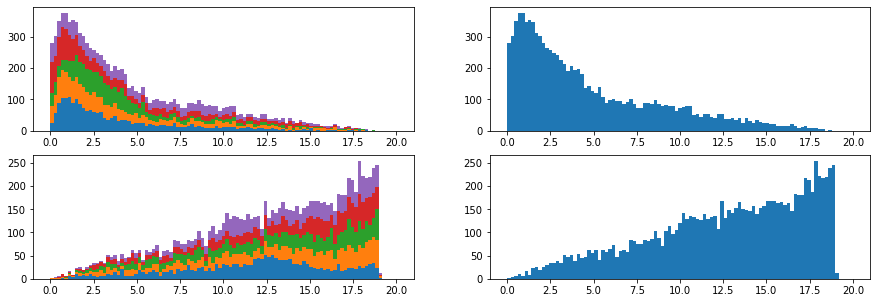

In [54]:
exp_diff_tau_array = np.array([this_trace["tau"] for this_trace in exp_diff_traces])

bins = np.linspace(0,20,100)
fig, ax = plt.subplots(2,2, figsize = (15,5))
ax[0,0].hist(exp_diff_tau_array[...,0].T, bins, stacked = 'true');
ax[0,1].hist(exp_diff_tau_array[...,0].flatten(), bins, stacked = 'true');
ax[1,0].hist(exp_diff_tau_array[...,1].T, bins, stacked = 'true');
ax[1,1].hist(exp_diff_tau_array[...,1].flatten(), bins, stacked = 'true');


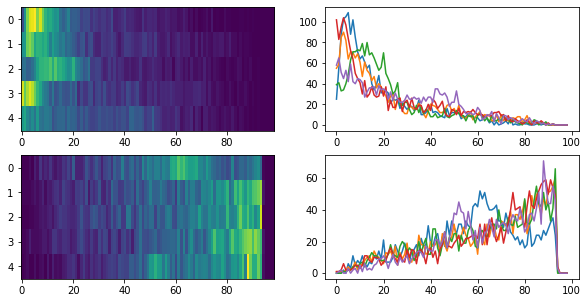

In [104]:
exp_diff_tau_hists = np.array([[np.histogram(x, bins)[0] for x in exp_diff_tau_array[...,this_tau]] for this_tau in range(2)])
fig,ax = plt.subplots(2,2, figsize = (10,5))
ax[0,0].imshow(exp_diff_tau_hists[0],aspect='auto');
ax[0,1].plot(exp_diff_tau_hists[0].T);
ax[1,0].imshow(exp_diff_tau_hists[1],aspect='auto');
ax[1,1].plot(exp_diff_tau_hists[1].T);

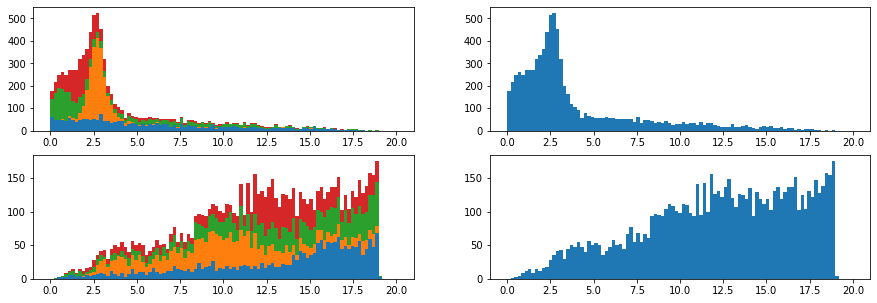

In [96]:
con_diff_tau_array = np.array([this_trace["tau"] for this_trace in con_diff_traces])

bins = np.linspace(0,20,100)
fig, ax = plt.subplots(2,2, figsize = (15,5))
ax[0,0].hist(con_diff_tau_array[...,0].T, bins, stacked = 'true');
ax[0,1].hist(con_diff_tau_array[...,0].flatten(), bins, stacked = 'true');
ax[1,0].hist(con_diff_tau_array[...,1].T, bins, stacked = 'true');
ax[1,1].hist(con_diff_tau_array[...,1].flatten(), bins, stacked = 'true');


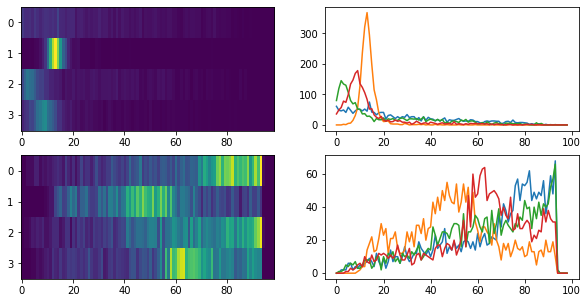

In [105]:
con_diff_tau_hists = np.array([[np.histogram(x, bins)[0] for x in con_diff_tau_array[...,this_tau]] for this_tau in range(2)])
fig,ax = plt.subplots(2,2, figsize = (10,5))
ax[0,0].imshow(con_diff_tau_hists[0],aspect='auto');
ax[0,1].plot(con_diff_tau_hists[0].T);
ax[1,0].imshow(con_diff_tau_hists[1],aspect='auto');
ax[1,1].plot(con_diff_tau_hists[1].T);